In [1]:
%matplotlib inline 
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt

### Extracting simulation data

$X \sim (p, d)$

$Y \sim (p, T)$

where:

$p$ = number of stocks

$d$ = number of features

$T$ = samples size

In [2]:
char = pd.read_csv("data_simulation/1.csv")
returns = pd.read_csv("data_simulation/return.csv")

X = char 
Y = returns

p, d = X.shape
T = Y.shape[1]

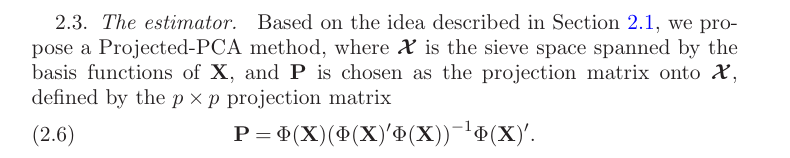

/home/czar/.local/lib/python3.10/site-packages/sklearn/base.py:413: UserWarning: X has feature names, but PolynomialFeatures was fitted without feature names
  warnings.warn(


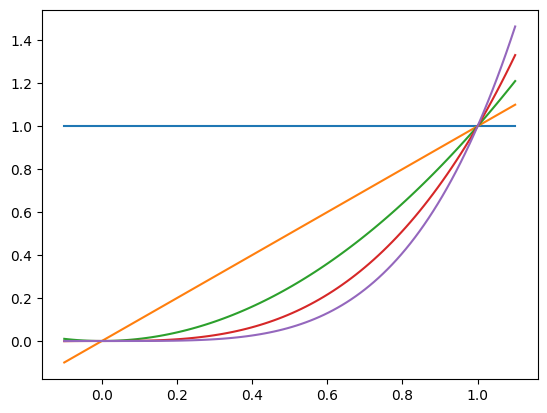

In [3]:
from sklearn.preprocessing import SplineTransformer, PolynomialFeatures

def gen_sieve_basis(f_class, plot=True):
    model = None
    if f_class == 'pol': # POLYNOMIAL
        # training RANGE is not important for polynomial... transform extends domain to wherever we need
        x_plot = np.linspace(-0.1, 1.1,  100) 
        x_train = np.linspace(0, 1, 100)
        x_train = x_train[:, np.newaxis]
        x_plot = x_plot[:, np.newaxis]

        pol = PolynomialFeatures(degree=4).fit(x_train)
        if plot: plt.plot(x_plot, pol.transform(x_plot))
        model = pol
    
    elif f_class == 'spl': # SPLINE
        # training RANGE is important for spline !! (read doc to understand .transform() at the edges)
        x_train_spline = np.linspace(X.min()-1, X.max()+1, 100)
        x_plot_spline = np.linspace(X.min()-1.1, X.max()+1.1, 100)

        spl = SplineTransformer(n_knots=4, degree=5).fit(x_train_spline) 
        if plot: plt.plot(x_plot_spline, spl.transform(x_plot_spline))
        model = spl
        
    PHI = model.transform(X)
    return PHI, model

PHI, model = gen_sieve_basis('pol', plot=True)
P = PHI @ np.linalg.inv(PHI.T @ PHI) @ PHI.T

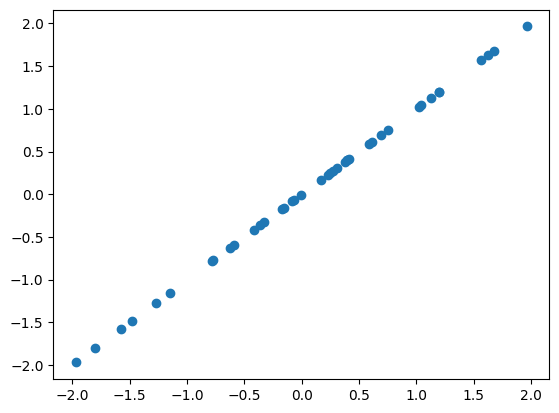

In [4]:
# little test
plt.scatter(X, PHI[:, 1])

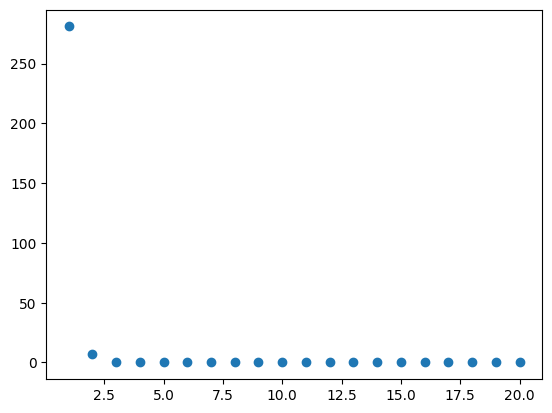

estimated K = 2


In [5]:
def PCA(M : np.ndarray, K : int = 0, plot:bool = False) -> np.ndarray :
    
    # get eigenvalues and eigenvectors
    # print(M-M.T)
    values, vectors = np.linalg.eigh(M)

    # sort by eigenvalues (decreasing)
    ind = np.argsort(values)[::-1]
    values, vectors = values[ind], vectors.T[ind]
    vectors = vectors.T
    
    # plot eigenvalues
    if plot: 
        plt.scatter(np.arange(1,1+len(ind)), values)
        plt.show()
    
    # estimate K
    if not K:
        K = 1 + np.argmax([values[i]/values[i+1] for i in range(len(values)-1)])
        print(f"estimated K = {K}")
        
    # return K first eigenvectors
    return np.asarray(vectors[:,:K])

# calculate loading factors
T = Y.shape[1]
F_hat = PCA(1/T * Y.T  @ P @ Y, K = 0, plot = True)

# normalize
F_hat = np.sqrt(T) * F_hat

# signal correction (for comparison)
if F_hat.mean() < 0:
    F_hat = -F_hat

3.143906153813318e-14


,0,1
0,-2.023575e-15,4.566584e-16
1,3.367132e-01,-9.416072e-01
2,8.577474e-15,1.164306e-15
3,9.416072e-01,3.367132e-01
4,-2.506051e-15,-4.252316e-16


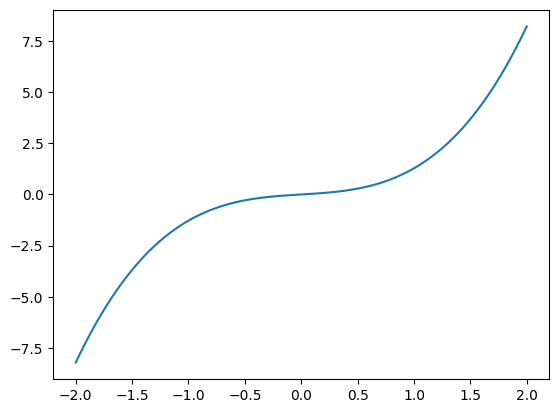

In [6]:
# pt.3 ~ remaining estimations (goal: GAMA and B)

# est. gamma
Gx = 1/T * P @ Y @ F_hat
LAMBDA = 1/T * Y @ F_hat

GAMMA = LAMBDA - Gx
print(np.linalg.norm(GAMMA, ord ='fro')) # should be zero, OK

# est. B
B = 1/T*np.linalg.multi_dot([np.linalg.inv(PHI.T @ PHI), PHI.T, Y, F_hat]) 

# Plotting coefficients 
display(pd.DataFrame(B))


# plotting curves
curve = 0
x = np.linspace(-2, 2, 100)
x = x[:, np.newaxis]
plt.plot(x, model.transform(x) @ B[:,curve][:, np.newaxis])
# plt.plot(x, x**3)


In [7]:
Y_pred = LAMBDA @ F_hat.T

np.linalg.norm(np.asarray(Y_pred) - np.asarray(Y))

3.8476341916045673e-14